# Deep Learning practice

### Búsqueda y construcción del modelo de entrenamiento

In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('./train.csv',sep=';', decimal='.')
val = pd.read_csv('./val.csv',sep=';', decimal='.')
test = pd.read_csv('./test.csv',sep=';', decimal='.')

images = np.load('images.npy')
train_imgs = images[train['Unnamed: 0']]
val_imgs = images[val['Unnamed: 0']]
test_imgs = images[test['Unnamed: 0']]

Extraigo la variable objetivo y dropeo los índices para empezar a trabajar con los datos.

In [2]:
Y_train = train.Price
Y_val = val.Price
Y_test = test.Price

X_train = train.drop(columns=['Unnamed: 0','Price'])
X_val = val.drop(columns=['Unnamed: 0','Price'])
X_test = test.drop(columns=['Unnamed: 0','Price'])

Importo los paquetes necesarios

In [3]:
from keras.engine import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, concatenate
from keras.applications import VGG16
from keras.utils import to_categorical
import cv2

Using TensorFlow backend.


La siguiente función me permite crear un modelo denso lineal o categórico en base al parámetro "linear"

In [4]:
def create_dense(dim, linear=False):
    model = Sequential()
    model.add(Dense(200, input_dim=dim, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    
    if linear:
        model.add(Dense(12, activation='relu'))
        model.add(Dense(1, activation='linear'))
    else:
        model.add(Dense(12, activation='relu'))
        
    return model

Echo un primer vistazo al modelo con los hiperparámetros que mejor suelen funcionar a nivel general.

In [5]:
atts_model = create_dense(X_train.shape[1], linear=True)
atts_model.compile(loss='mse', optimizer='adam' , metrics=['mse'])
atts_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=25, batch_size=100)

Train on 6634 samples, validate on 738 samples
Epoch 1/25
6634/6634 [==============================] - 1s 135us/step - loss: 3513.7036 - mse: 3513.7034 - val_loss: 14282.8155 - val_mse: 14282.8154
Epoch 2/25
6634/6634 [==============================] - 0s 30us/step - loss: 3115.2304 - mse: 3115.2302 - val_loss: 127591.9870 - val_mse: 127592.0000
Epoch 3/25
6634/6634 [==============================] - 0s 29us/step - loss: 2522.5927 - mse: 2522.5928 - val_loss: 1973814.8015 - val_mse: 1973814.6250
Epoch 4/25
6634/6634 [==============================] - 0s 30us/step - loss: 3612.2261 - mse: 3612.2256 - val_loss: 1006874.5131 - val_mse: 1006874.5625
Epoch 5/25
6634/6634 [==============================] - 0s 30us/step - loss: 2267.5266 - mse: 2267.5264 - val_loss: 1641853.8349 - val_mse: 1641853.7500
Epoch 6/25
6634/6634 [==============================] - 0s 30us/step - loss: 1887.2092 - mse: 1887.2092 - val_loss: 1711922.8013 - val_mse: 1711922.8750
Epoch 7/25
6634/6634 [==================

In [6]:
print(f'MSE en test: {np.mean(((atts_model.predict(X_test) - Y_test.to_numpy().reshape(-1,1))**2).mean(axis=1))}')

MSE en test: 1272.0077008123938


No es excesivamente malo para ser un modelo tan simple. Ahora voy a definir un modelo para trabajar con las imágenes.

La siguiente función construye un modelo sencillo que puede generar una salida lineal o categórica dependiendo del parámetro "linear", y también permite añadir una salida final partiendo de una arquiectura base.

In [7]:
def create_cnn(shape, base=None, linear=False, density=128, mode='trainable'):
    
    if base:
        
        if mode == 'transfer_learning':
            for layer in base.layers: 
                layer.trainable = False            
        
        model = base.layers[-1].output
        model = Flatten()(model)
        model = Dense(density, activation='relu')(model)
        model = Dropout(0.3)(model)
        
        if linear:
            model = Dense(1, activation='linear')(model)
        else:
            model = Dense(12, activation='relu')(model)
            
        model = Model(base.input, model)
    
    else:
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=shape))
        model.add(Dropout(0.25))
    
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
        model.add(Dropout(0.25))
    
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
        model.add(Dropout(0.25))
    
        model.add(Flatten())
        model.add(Dense(density, activation='relu'))
        model.add(Dropout(0.5))
    
        if linear:
            model.add(Dense(1, activation='linear'))
        else:
            model.add(Dense(12, activation='relu'))
        
    return model

Reescalo las imágenes a la mitad de su resolución original por cuestiones de memoria RAM de mi GPU y después estandarizo los datos para que el modelo trabaje con números entre 0 y 1

In [8]:
shapes = []

for shape in (train_imgs.shape, val_imgs.shape, test_imgs.shape):
    shapes.append((shape[0],shape[1]//2,shape[2]//2,shape[3]))
    
train_imgs_res = np.zeros(shapes[0], dtype=int)
val_imgs_res = np.zeros(shapes[1], dtype=int)
test_imgs_res = np.zeros(shapes[2], dtype=int)        

for idx, img in zip(range(shapes[0][0]),train_imgs):
    train_imgs_res[idx] = cv2.resize(img, shapes[0][1:-1])

for idx, img in zip(range(shapes[1][0]),val_imgs):
    val_imgs_res[idx] = cv2.resize(img, shapes[1][1:-1])

for idx, img in zip(range(shapes[2][0]),test_imgs):
    test_imgs_res[idx] = cv2.resize(img, shapes[2][1:-1])
    
train_imgs_res = train_imgs_res / 255
val_imgs_res = val_imgs_res / 255
test_imgs_res = test_imgs_res / 255

Veamos cómo se comporta esta arquitectura

In [9]:
imgs_model = create_cnn(train_imgs_res.shape[1:], linear=True)
imgs_model.compile(loss='mse', optimizer='adam' , metrics=['mse'])
imgs_model.fit(train_imgs_res, Y_train, validation_data=(val_imgs_res, Y_val), epochs=3, batch_size=16)

Train on 6634 samples, validate on 738 samples
Epoch 1/3
6634/6634 [==============================] - 56s 8ms/step - loss: 3533.8644 - mse: 3533.8643 - val_loss: 3603.5449 - val_mse: 3603.5444
Epoch 2/3
6634/6634 [==============================] - 54s 8ms/step - loss: 3284.9164 - mse: 3284.9158 - val_loss: 3610.8911 - val_mse: 3610.8914
Epoch 3/3
6634/6634 [==============================] - 54s 8ms/step - loss: 3271.0443 - mse: 3271.0449 - val_loss: 3732.9472 - val_mse: 3732.9465


In [10]:
print(f'MSE en test: {np.mean(((imgs_model.predict(test_imgs_res) - Y_test.to_numpy().reshape(-1,1))**2).mean(axis=1))}')

MSE en test: 3182.0093433880124


Resultados horribles. Voy a probar con VGG16 cargando los pesos de imagenet.

In [11]:
shapes = []

for shape in (train_imgs.shape, val_imgs.shape, test_imgs.shape):
    shapes.append((shape[0],48,48,3)) # Reescalo a 48, 48, 3 para poder usar VGG16
    
train_imgs_res = np.zeros(shapes[0], dtype=int)
val_imgs_res = np.zeros(shapes[1], dtype=int)
test_imgs_res = np.zeros(shapes[2], dtype=int)        

for idx, img in zip(range(shapes[0][0]),train_imgs):
    train_imgs_res[idx] = cv2.resize(img, shapes[0][1:-1])

for idx, img in zip(range(shapes[1][0]),val_imgs):
    val_imgs_res[idx] = cv2.resize(img, shapes[1][1:-1])

for idx, img in zip(range(shapes[2][0]),test_imgs):
    test_imgs_res[idx] = cv2.resize(img, shapes[2][1:-1])
    
train_imgs_res = train_imgs_res / 255
val_imgs_res = val_imgs_res / 255
test_imgs_res = test_imgs_res / 255

In [12]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=train_imgs_res.shape[1:])
vgg16_model = create_cnn(train_imgs_res.shape[1:], base=vgg16_model, linear=True, density=2500, mode='transfer_learning')
vgg16_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
vgg16_model.fit(train_imgs_res, Y_train, validation_data=(val_imgs_res, Y_val), epochs=3, batch_size=100)

Train on 6634 samples, validate on 738 samples
Epoch 1/3
6634/6634 [==============================] - 7s 1ms/step - loss: 3564.1297 - mse: 3564.1296 - val_loss: 3646.3452 - val_mse: 3646.3452
Epoch 2/3
6634/6634 [==============================] - 5s 807us/step - loss: 3028.2040 - mse: 3028.2041 - val_loss: 3649.9255 - val_mse: 3649.9255
Epoch 3/3
6634/6634 [==============================] - 5s 805us/step - loss: 3003.4130 - mse: 3003.4131 - val_loss: 3626.9171 - val_mse: 3626.9172


In [13]:
print(f'MSE en test: {np.mean(((vgg16_model.predict(test_imgs_res) - Y_test.to_numpy().reshape(-1,1))**2).mean(axis=1))}')

MSE en test: 3111.819489143141


Hasta aquí he definido dos funciones que permiten generar modelos lineales y categóricos de una forma sencilla. Ahora voy a trabajar más a fondo con estos dos modelos y a unificarlos.

Primero voy a pasar la variable objetivo a categórica para trabajar con las categorías "barato", "asequible" y "caro", ya que seguramente serán más fáciles de predecir que un precio aproximado.

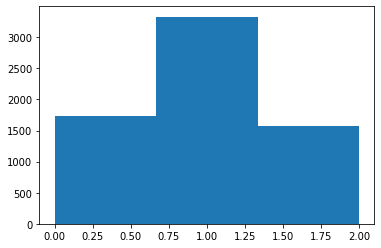

In [14]:
import matplotlib.pyplot as plt

Y_train_cat = []
for y in Y_train:
    if y < 35: Y_train_cat.append(0)
    elif y < 85: Y_train_cat.append(1)
    else: Y_train_cat.append(2)
        
plt.hist(Y_train_cat, bins=3)
plt.show()

In [15]:
Y_val_cat = []
for y in Y_val:
    if y < 35: Y_val_cat.append(0)
    elif y < 85: Y_val_cat.append(1)
    else: Y_val_cat.append(2)
        
Y_test_cat = []
for y in Y_test:
    if y < 35: Y_test_cat.append(0)
    elif y < 85: Y_test_cat.append(1)
    else: Y_test_cat.append(2)
        
Y_train_cat = to_categorical(Y_train_cat)
Y_val_cat = to_categorical(Y_val_cat)
Y_test_cat = to_categorical(Y_test_cat)

Ahora que tenemos un buen reparto de los valores en categorías, veamos como se comportan nuestros modelos si los unificamos.

In [16]:
atts_model = create_dense(X_train.shape[1], linear=False)

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=train_imgs_res.shape[1:])
vgg16_model = create_cnn(train_imgs_res.shape[1:], base=vgg16_model, linear=False, density=1028, mode='transfer_learning')

In [17]:
combined = concatenate([atts_model.output, vgg16_model.output])
z = Dense(3, activation='softmax')(combined)
combined = Model([atts_model.input, vgg16_model.input], z)

In [18]:
combined.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])
combined.fit([X_train, train_imgs_res], Y_train_cat, validation_data=([X_val, val_imgs_res], Y_val_cat),
             epochs=40, batch_size=512)

Train on 6634 samples, validate on 738 samples
Epoch 1/40
6634/6634 [==============================] - 10s 1ms/step - loss: 4.4707 - accuracy: 0.3862 - val_loss: 4.7953 - val_accuracy: 0.4973
Epoch 2/40
6634/6634 [==============================] - 4s 628us/step - loss: 1.4803 - accuracy: 0.4644 - val_loss: 2.9479 - val_accuracy: 0.5203
Epoch 3/40
6634/6634 [==============================] - 4s 629us/step - loss: 1.0741 - accuracy: 0.5051 - val_loss: 2.8437 - val_accuracy: 0.5149
Epoch 4/40
6634/6634 [==============================] - 4s 629us/step - loss: 0.9809 - accuracy: 0.5378 - val_loss: 7.5908 - val_accuracy: 0.5136
Epoch 5/40
6634/6634 [==============================] - 4s 628us/step - loss: 1.0395 - accuracy: 0.5419 - val_loss: 2.2263 - val_accuracy: 0.5366
Epoch 6/40
6634/6634 [==============================] - 4s 629us/step - loss: 0.9613 - accuracy: 0.5549 - val_loss: 2.1178 - val_accuracy: 0.5488
Epoch 7/40
6634/6634 [==============================] - 4s 628us/step - loss: 

In [19]:
print(f'Accuracy in test: {sum(np.array([np.argmax(comb) for comb in combined.predict([X_test,test_imgs_res])])==np.array([np.argmax(real) for real in Y_test_cat]))/len(Y_test)}')

Accuracy in test: 0.6274403470715835
